In [3]:
# ================== SETUP ==================
import os, random, numpy as np, torch, timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import mlflow.pytorch
import dagshub

In [4]:
# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [5]:
# ================== PATHS & CONSTANTS ==================
data_dir = "data"   # dataset folder path
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 1
LR = 3e-4
save_path = "models/best_vit_brain_tumor.pth"

In [10]:
dagshub.init(repo_name="ML_Project", repo_owner="Karam-Abbas" , mlflow=True)

⠋ Waiting for authorization

Accessing as Karam-Abbas

Initialized MLflow to track repo "Karam-Abbas/ML_Project"

Repository Karam-Abbas/ML_Project initialized!

In [11]:
# ================== MLFLOW SETUP ==================
mlflow.set_experiment("Brain_Tumor_Classification")
mlflow.start_run(run_name=f"ViT_base_{EPOCHS}epochs")

# Log parameters
mlflow.log_param("model_name", "vit_base_patch16_224")
mlflow.log_param("img_size", IMG_SIZE)
mlflow.log_param("batch_size", BATCH_SIZE)
mlflow.log_param("epochs", EPOCHS)
mlflow.log_param("learning_rate", LR)
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("device", str(device))
mlflow.log_param("seed", seed)

print("✅ MLflow run started")

2025/12/08 21:22:28 INFO mlflow.tracking.fluent: Experiment with name 'Brain_Tumor_Classification' does not exist. Creating a new experiment.


✅ MLflow run started


In [12]:
# ================== TRANSFORMS ==================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [13]:
# ================== DATASET & SPLITS ==================
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "Training"), transform=train_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "Testing"), transform=val_test_transform)

print("Classes:", train_dataset.classes)

# Optional: split train into train/val
train_idx, val_idx = train_test_split(
    range(len(train_dataset)), 
    test_size=0.15, 
    stratify=train_dataset.targets, 
    random_state=seed
)

train_ds = Subset(train_dataset, train_idx)
val_ds = Subset(train_dataset, val_idx)
test_ds = test_dataset  # already separate

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Train: 4855 | Val: 857 | Test: 1312


In [14]:
# ================== MODEL (ViT) ==================
num_classes = len(train_dataset.classes)
model_name = "vit_base_patch16_224"  # can change to vit_tiny_patch16_224

model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

# Freeze all layers
for p in model.parameters():
    p.requires_grad = False

# Replace classifier head
if hasattr(model, "reset_classifier"):
    model.reset_classifier(num_classes=num_classes)
else:
    model.head = nn.Linear(model.head.in_features, num_classes)

model = model.to(device)

# ================== TRAINING SETUP ==================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [15]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [17]:
# ================== TRAINING LOOP ==================
best_val_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    total_loss, preds_all, labels_all = 0.0, [], []
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds_all.extend(outputs.argmax(1).cpu().numpy())
        labels_all.extend(labels.cpu().numpy())
    train_acc = accuracy_score(labels_all, preds_all)
    train_loss = total_loss / len(train_ds)

    # Validation
    model.eval()
    val_preds, val_labels, val_loss = [], [], 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_acc = accuracy_score(val_labels, val_preds)
    val_loss /= len(val_ds)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")
    # Log metrics to MLflow
    mlflow.log_metric("train_loss", train_loss, step=epoch)
    mlflow.log_metric("train_accuracy", train_acc, step=epoch)
    mlflow.log_metric("val_loss", val_loss, step=epoch)
    mlflow.log_metric("val_accuracy", val_acc, step=epoch)
    mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)
    mlflow.pytorch.log_model(model, f"checkpoint_epoch_{epoch+1}.pth")
    
    # --- end of epoch ---
    torch.save(model.state_dict(), f"models/checkpoint_epoch_{epoch+1}.pth")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        mlflow.pytorch.log_model(model, "best_model")
        torch.save(model.state_dict(), save_path)
        print("✅ Saved best model")

Epoch 1/1 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:38<00:00,  1.39it/s]


Epoch 1: Train Loss=0.4787 Acc=0.8204 | Val Loss=0.4471 Acc=0.8506


/opt/miniconda3/envs/jp/lib/python3.10/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/miniconda3/envs/jp/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


✅ Saved best model


In [ ]:
# ================== EVALUATION ON TEST SET ==================
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
cm = confusion_matrix(y_true, y_pred)

print("\n=== FINAL TEST RESULTS ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("Confusion Matrix:\n", cm)

# Log test metrics to MLflow
mlflow.log_metric("test_accuracy", acc)
mlflow.log_metric("test_precision", prec)
mlflow.log_metric("test_recall", rec)
mlflow.log_metric("test_f1_score", f1)

# Log confusion matrix as figure
fig, ax = plt.subplots(figsize=(8, 6))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
mlflow.log_figure(fig, "confusion_matrix.png")
plt.close()

# Log the best model
mlflow.pytorch.log_model(model, "model")
print("✅ Model and metrics logged to MLflow")

Testing: 100%|██████████████████████████████████| 82/82 [00:40<00:00,  2.01it/s]


=== FINAL TEST RESULTS ===
Accuracy:  0.8413
Precision: 0.8367
Recall:    0.8324
F1-score:  0.8328
Confusion Matrix:
 [[256  42   0   2]
 [ 47 208  33  18]
 [ 12   7 386   0]
 [ 26  21   0 253]]


      glioma:   1.3%
  meningioma:   1.4%
     notumor:  97.3%
   pituitary:   0.0%


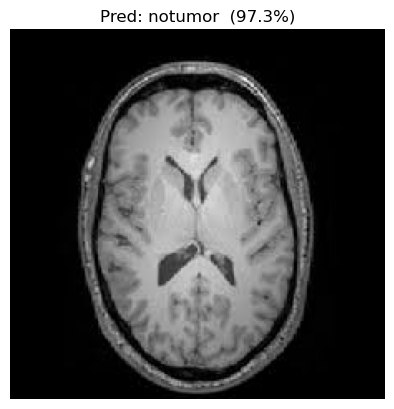

In [24]:
# ================== SINGLE IMAGE INFERENCE ==================
import torchvision.transforms as T
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

# same preprocessing as validation
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# load best checkpoint
model.load_state_dict(torch.load("models/best_vit_brain_tumor.pth", map_location=device))
model.eval()

def predict_image(path):
    img = Image.open(path).convert('RGB')
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs  = F.softmax(logits, dim=1).cpu().numpy().ravel()

    class_names = train_dataset.classes          # ['glioma', 'meningioma', 'no tumor', 'pituitary']
    top = probs.argmax()

    # pretty print
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[top]}  ({probs[top]:.1%})")
    for cls, p in zip(class_names, probs):
        print(f"{cls:>12}: {p:>6.1%}")
    plt.show()

# usage
predict_image("download.jpeg")